# Introduction


Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a very brief presentation covering the following points:
    * Introduction to the problem (what are we trying to achieve and why) - max 1 slide
    * Libraries used - max 1 slide
    * Data Processing Pipeline - max 2 slides
    * Feature Engineering (if relevant) - max 1 slide
    * Modeling - max 1 slide
    * Results & Visualization - max 2 slides
* The goal of the presentation is to make it **understandable by a business person**, apart from how modeling techniques which do not have to be explained how they work.

## Articles from which I got the ideas to analyze the dataset:

1. Parlak, Cevahir & Diri, Banu. (2013). **Emotion recognition from the human voice**. _2013 21st Signal Processing and Communications Applications Conference, SIU 2013. 1-4. 10.1109/SIU.2013.6531196_
2. Kerkeni, Leila & Serrestou, Youssef & Mbarki, Mohamed & Raoof, Kosai & Mahjoub, Mohamed. (2018). **Speech Emotion Recognition: Methods and Cases Study**. _175-182. 10.5220/0006611601750182_
3. Chandrasekar, Purnima & Chapaneri, Santosh & Jayaswal, Deepak. (2014). **Emotion Recognition from Speech using Discriminative Features**. _International Journal of Computer Applications. 101. 31-36. 10.5120/17775-8913_ 

# Tutorials, analysis I have read and which gave my ideas:
* https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html

            Instead of directly using the sound file as an amplitude vs time signal we use a log-scaled mel-spectrogram with 128 components (bands) covering the audible frequency range (0-22050 Hz), 
            using a window size of 23 ms (1024 samples at 44.1 kHz) and a hop size of the same duration. This conversion takes into account the fact that human ear hears sound on log-scale, 
            and closely scaled frequency are not well distinguished by the human Cochlea. The effect becomes stronger as frequency increases. Hence we only take into account power in different frequency bands. 
* 

# Libraries Loading

In [1]:
#general 
import numpy as np
import pandas as pd

#utilities for data analysis
import pandas_profiling

#plot utilities
import matplotlib.pyplot as plt
import seaborn as sns

#audio processing
import librosa
import librosa.display

import python_speech_features

#for machine learning models
import math

import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score



import time

#needed for pipeline
import os
import sys

sns.set()
%matplotlib inline

In [2]:
sys.path.insert(0, 'src/')
#src files 
import utilities
import data_processing as dp
import neural_nets 

# Data pipeline and features extraction

first we load the data

In [3]:
samples, emotion = dp.load_data(path = "data/wav")

In [4]:
dp.import_wave_wrapper(samples)

Then we extract some features: 

 - mfcc
 - spectral measurements
 - logfbank
 - ...
 
All of these were proposed in the articles aforementioned

 <span style="color:red"> Since it takes some time extract the features and profile the resulting dataframe one can just skip this part to the next red writing and load the resulting dataframe stored in </span> `data/features.csv` 

In [5]:
dp.extract_feature(samples, librosa.feature.mfcc, "mfcc")

In [6]:
dp.extract_feature(samples, librosa.feature.spectral_centroid, "spectral_centroid")

In [7]:
dp.extract_feature(samples, librosa.feature.spectral_rolloff, "spectral_rolloff")

In [8]:
dp.extract_feature(samples, python_speech_features.logfbank , "logfbank")

In [9]:
dp.extract_feature(samples, python_speech_features.ssc, "spectral_subband_centroid")

Then we extract a measure of the ratio between the spoken time and the unspoken time of the audio sample

This part is done manually and could be greatly improved as for the speed and the accuracy

In [10]:
dp.ratio(samples)

Now let's examine our dataframe with our newly added features

In [11]:
samples.head()

,id,actor,text,emotion,sound,length,mfcc_mean,mfcc_sd,mfcc_median,mfcc_max,...,logfbank_sd,logfbank_median,logfbank_max,logfbank_min,spectral_subband_centroid_mean,spectral_subband_centroid_sd,spectral_subband_centroid_median,spectral_subband_centroid_max,spectral_subband_centroid_min,ratio
0,data/wav/03b10Wc.wav,03,b10,4,"[0.00012207031, -0.00039672852, -0.0002746582,...",39072,-3.895151,46.586504,-2.257769,182.010078,...,4.233969,-9.322322,-0.697060,-24.167197,347.567326,220.464140,323.985583,776.815976,13.265750,0.196729
1,data/wav/15a05Na.wav,15,a05,6,"[0.00036621094, 0.00045776367, 0.0009460449, 0...",49935,2.928844,53.183098,5.190972,202.840489,...,3.762019,-11.025209,-1.556346,-22.480588,347.449888,220.688609,324.281057,780.310658,13.540170,0.265555
2,data/wav/12a05Ta.wav,12,a05,5,"[0.0029907227, 0.0027160645, 0.0032653809, 0.0...",85764,1.769312,60.040993,4.691081,175.701415,...,3.535917,-11.367481,-0.252393,-21.435957,347.440277,220.762034,324.396715,778.712336,12.941210,0.320665
3,data/wav/10a07Ta.wav,10,a07,5,"[0.00024414062, -0.00024414062, -0.00076293945...",31293,6.343056,55.040812,8.138438,160.072857,...,3.450362,-10.460599,0.252841,-19.892496,347.465065,221.027697,324.061949,777.401728,12.851754,0.137927
4,data/wav/14a02La.wav,14,a02,3,"[0.0002746582, -0.0002746582, 0.00012207031, 0...",31211,1.670838,55.751518,2.586206,186.564716,...,3.684091,-11.053970,-1.614739,-22.178161,347.396854,220.770733,323.205094,779.215365,13.313539,0.312158


We do some profiling of the data to gain insight of the ditribution of our data and save the results

In [12]:
pandas_profiling.ProfileReport(samples.drop(['id',"actor","text","emotion","sound"], axis=1)).to_file(outputfile="results/features_exploration.html")

In [13]:
samples.to_csv("data/features.csv",index=False)

 <span style="color:red"> uncomment the following line to load the resulting dataframe stored in `data/features.csv` </span>

In [5]:
samples = pd.read_csv("data/features.csv")

#necessary to re_import the sound, otherwise treated as a string from the loading process
dp.import_wave_wrapper(samples)

From the report we get that:
- sampling rate is constant 16000 and can be then eliminated
- length has some outliers above 99447 and below 23414
- from the others histograms there do not seem to be outliers or missing values which have been replaced by a default value

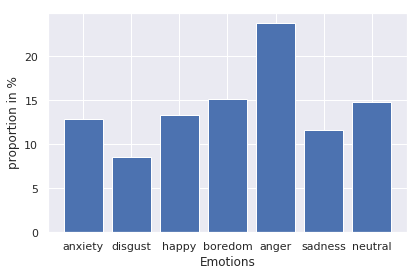

In [6]:
proportion = []
total = len(samples.index)
for e in np.arange(len(emotion)):
    proportion.append(100*len(samples[samples["emotion"]==e].index)/total)
    

x = np.arange(len(emotion))


fig, ax = plt.subplots()
plt.bar(x, proportion)
plt.xticks(x, emotion)
plt.xlabel("Emotions")
plt.ylabel("proportion in %")
plt.tight_layout()
#plt.savefig('results/plots/proportion.png',dpi = 1000)
plt.show()

In [8]:
samples[(samples["actor"] == samples["actor"][23]) & (samples["text"] == samples["text"][23])]

,id,actor,text,emotion,sound,length,mfcc_mean,mfcc_sd,mfcc_median,mfcc_max,...,logfbank_sd,logfbank_median,logfbank_max,logfbank_min,spectral_subband_centroid_mean,spectral_subband_centroid_sd,spectral_subband_centroid_median,spectral_subband_centroid_max,spectral_subband_centroid_min,ratio
23,data/wav/03a07Wc.wav,3,a07,4,"[6.1035156e-05, 0.0007019043, 0.0007324219, 0....",33401,-2.932896,45.819030,-1.995782,175.443725,...,4.121605,-8.915630,-1.005504,-24.288764,347.589238,220.420316,324.080228,779.176019,13.319966,0.184475
95,data/wav/03a07Fa.wav,3,a07,2,"[-0.0005493164, -0.0011901855, -0.0022888184, ...",34141,1.323991,44.839523,1.785695,140.781965,...,3.789585,-9.127146,0.336442,-23.619038,347.517847,220.540533,323.955220,776.151806,13.334790,0.212350
217,data/wav/03a07Fb.wav,3,a07,2,"[0.0025634766, 0.0026245117, 0.0025634766, 0.0...",39198,-0.559501,41.486846,0.058653,142.524073,...,3.731525,-8.632639,-0.224006,-22.616822,347.510065,220.548576,324.705580,775.127183,13.703880,0.122316
225,data/wav/03a07La.wav,3,a07,3,"[-0.007751465, -0.0075683594, -0.007751465, -0...",38425,5.668417,50.179973,6.141254,197.421573,...,3.325621,-10.036351,-0.041171,-19.970633,347.416017,220.779266,324.498736,779.364941,13.389675,0.109395
371,data/wav/03a07Nc.wav,3,a07,6,"[0.00018310547, 0.00045776367, 0.0002746582, 0...",28610,5.710174,50.949592,5.409512,204.430558,...,3.826613,-10.109882,-0.642875,-21.855272,347.420943,220.933136,324.803626,777.601406,12.895386,0.184336


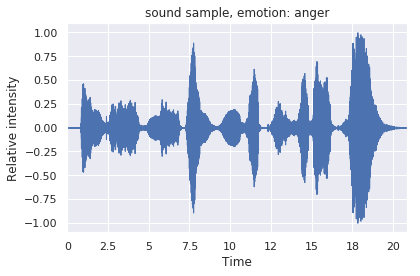

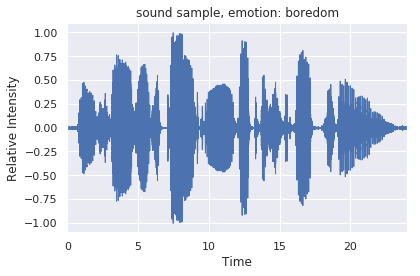

In [9]:
i =23
y = samples["sound"][i]
librosa.display.waveplot(y,1600)
plt.ylabel("Relative intensity")
plt.title("sound sample, emotion: {}".format(emotion[samples["emotion"][i]]))
plt.tight_layout()
#plt.savefig("results/plots/sound_samples.png", dpi =100)
plt.show()

i = 225
y = samples["sound"][i]
librosa.display.waveplot(y,1600)
plt.ylabel("Relative Intensity")
plt.title("sound sample, emotion: {}".format(emotion[samples["emotion"][i]]))
plt.tight_layout()
#plt.savefig("results/plots/sound_samples_1.png", dpi =100)
plt.show()

# Neural Nets

#### Fully connected neural network with 4 hidden layers

In [7]:
features = ['length', 'mfcc_mean', 'mfcc_sd', 'mfcc_median', 'mfcc_max', 'mfcc_min',
       'spectral_centroid_mean', 'spectral_centroid_sd',
       'spectral_centroid_median', 'spectral_centroid_max',
       'spectral_centroid_min', 'spectral_rolloff_mean', 'spectral_rolloff_sd',
       'spectral_rolloff_median', 'spectral_rolloff_max',
       'spectral_rolloff_min', 'logfbank_mean', 'logfbank_sd',
       'logfbank_median', 'logfbank_max', 'logfbank_min',
       'spectral_subband_centroid_mean', 'spectral_subband_centroid_sd',
       'spectral_subband_centroid_median', 'spectral_subband_centroid_max',
       'spectral_subband_centroid_min', 'ratio']

#creating torch tensor from the dataframe
X = torch.tensor(samples[features].values).type(torch.FloatTensor)
target = torch.tensor(samples["emotion"].values).type(torch.LongTensor)

#splitting the data into test and train
train_input, train_target, test_input, test_target = utilities.split_train_test(X,target,4/5)

epoch   0, loss training: 1.625, train accuracy 44.159,  test accuracy 34.579
epoch  10, loss training: 0.393, train accuracy 86.449,  test accuracy 59.813
epoch  20, loss training: 0.115, train accuracy 97.430,  test accuracy 67.290
epoch  30, loss training: 0.102, train accuracy 96.495,  test accuracy 71.028
epoch  40, loss training: 0.010, train accuracy 100.000,  test accuracy 71.028
epoch  50, loss training: 0.005, train accuracy 100.000,  test accuracy 70.093
epoch  60, loss training: 0.003, train accuracy 100.000,  test accuracy 71.028
epoch  70, loss training: 0.002, train accuracy 100.000,  test accuracy 71.028
epoch  80, loss training: 0.001, train accuracy 100.000,  test accuracy 71.963
epoch  90, loss training: 0.001, train accuracy 100.000,  test accuracy 72.897
epoch 100, loss training: 0.001, train accuracy 100.000,  test accuracy 72.897
epoch 110, loss training: 0.001, train accuracy 100.000,  test accuracy 71.963
epoch 120, loss training: 0.001, train accuracy 100.000,

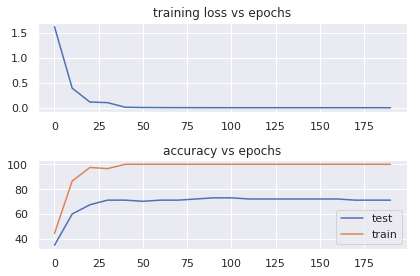

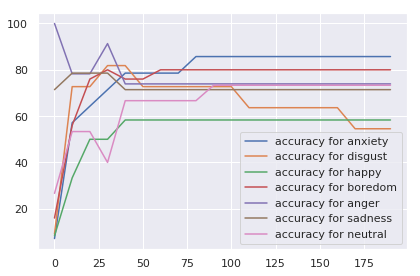

In [8]:
batch_size = int(train_input.size(0)/10)
epochs = 200



model = neural_nets.Net()
model.float()

learning_rate = 1e-4
# create a stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())
# create a loss function
criterion = nn.CrossEntropyLoss()

neural_nets.train_model(model, train_input, train_target, test_input, test_target, optimizer, criterion, batch_size, epochs, rate_print = 10, chrono=True, plots=True, save=True, title='fully connected')

1th fold training


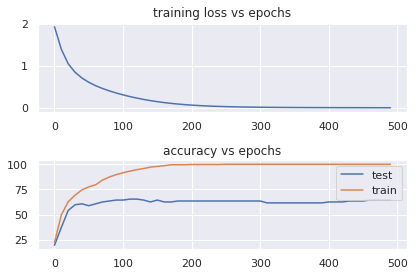

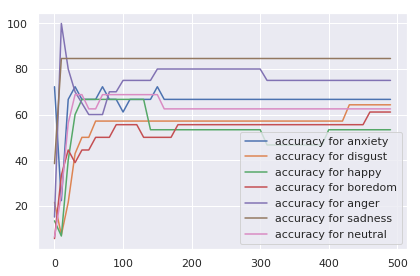

2th fold training


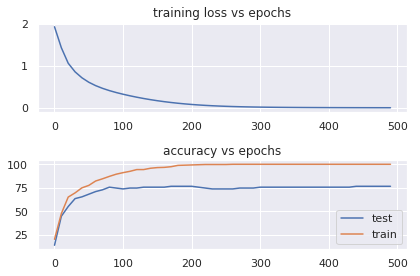

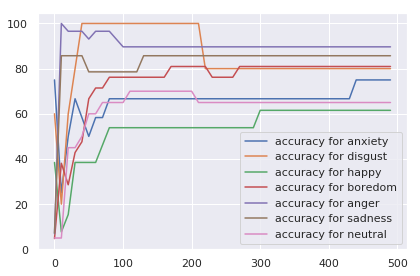

3th fold training


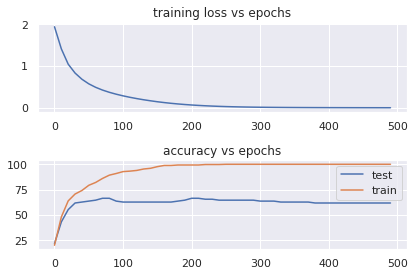

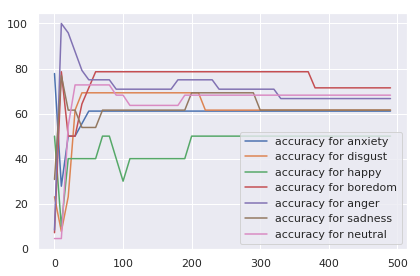

4th fold training


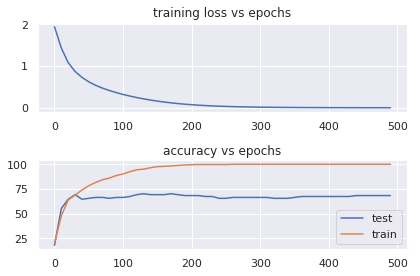

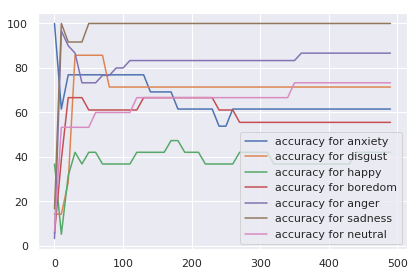

5th fold training


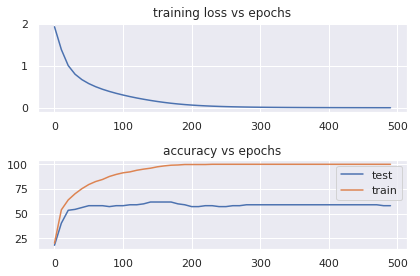

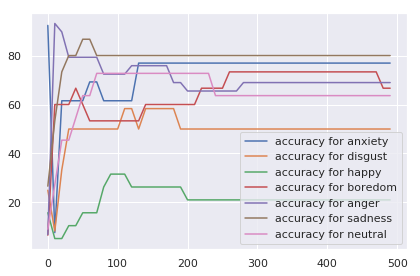

In [12]:
net = neural_nets.Net()

mu,std = X.mean(0), X.std(0)
X_normalized = X.sub(mu).div(std)

global_accuracy, per_class_accuracy, confusion_matrix = neural_nets.cross_validation_nn(net, X_normalized, target, k_fold = 5, epochs = 500, buffer_path = "src/buffer",confusion_matrix=True)

In [13]:
confusion_matrix

,anxiety,disgust,happy,boredom,anger,sadness,neutral
anxiety,65.22,2.90,14.49,5.80,4.35,0.00,7.25
disgust,10.87,58.70,6.52,2.17,10.87,6.52,4.35
happy,12.68,8.45,39.44,0.00,36.62,1.41,1.41
boredom,3.70,0.00,3.70,65.43,0.00,11.11,16.05
anger,3.94,3.94,14.17,0.79,77.17,0.00,0.00
sadness,0.00,3.23,0.00,11.29,0.00,80.65,4.84
neutral,8.86,5.06,2.53,17.72,0.00,1.27,64.56


From the cross validation we get the following approximation of accuracy

In [25]:
pd.DataFrame(np.round(np.insert(per_class_accuracy, 0,global_accuracy),decimals = 2), index= ['global','anxiety', 'disgust', 'happy', 'boredom', 'anger', 'sadness', 'neutral']).T.to_csv("results/accuracy.csv")
pd.DataFrame(np.round(np.insert(per_class_accuracy, 0,global_accuracy),decimals = 2), index= ['global','anxiety', 'disgust', 'happy', 'boredom', 'anger', 'sadness', 'neutral']).T

,global,anxiety,disgust,happy,boredom,anger,sadness,neutral
0,65.79,68.25,65.45,45.61,67.14,77.39,82.37,66.53


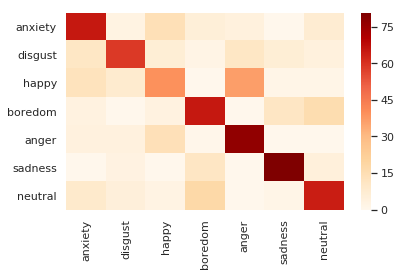

In [21]:
sns.heatmap(confusion_matrix,cmap="OrRd")
plt.tight_layout()
#plt.savefig("results/plots/confusion_matrix.png",dpi = 1000)
plt.show()

# Other approach that were performed but revealed less accurate 

#### convolutional neural network based on the images representation of the sound samples

we reduce our problem to image classification

In [16]:
batch_size = 107
epochs = 200
rate_print = 5


model_conv = neural_nets.convNet()
model_conv.float()

# create a stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model_conv.parameters())

# create a loss function
criterion = nn.CrossEntropyLoss()

As before, since computing the catual graphical representation, the output tensor is stored in `'data/image_like.pt'` and can be loaded below. If you wish to compute it, just uncomment the first line and comment the last one 

In [17]:
#data_conv = dp.graphic_representation_audio(samples)
#torch.save(data_conv, 'data/image_like.pt')
data_conv =  torch.load('data/image_like.pt')

train_input, train_target, test_input, test_target  = utilities.split_train_test(data_conv,target)

visualization of the data

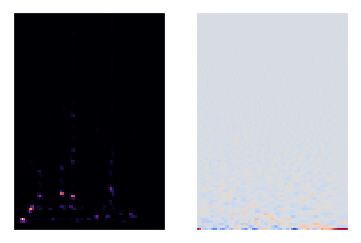

In [18]:
index = 300
plt.subplot(1,2,1)
librosa.display.specshow(data_conv[index,0].numpy())
plt.subplot(1,2,2)
librosa.display.specshow(data_conv[index,1].numpy())
plt.show()

Actual training of the neural network

epoch   0, loss training: 1.836, train accuracy 22.897,  test accuracy 27.103
epoch  10, loss training: 0.810, train accuracy 73.832,  test accuracy 48.598
epoch  20, loss training: 0.230, train accuracy 95.794,  test accuracy 41.121
epoch  30, loss training: 0.045, train accuracy 100.000,  test accuracy 42.056
epoch  40, loss training: 0.013, train accuracy 100.000,  test accuracy 38.318
epoch  50, loss training: 0.007, train accuracy 100.000,  test accuracy 39.252
epoch  60, loss training: 0.004, train accuracy 100.000,  test accuracy 39.252
epoch  70, loss training: 0.003, train accuracy 100.000,  test accuracy 39.252
epoch  80, loss training: 0.002, train accuracy 100.000,  test accuracy 39.252
epoch  90, loss training: 0.002, train accuracy 100.000,  test accuracy 38.318
epoch 100, loss training: 0.001, train accuracy 100.000,  test accuracy 38.318
epoch 110, loss training: 0.001, train accuracy 100.000,  test accuracy 38.318
epoch 120, loss training: 0.001, train accuracy 100.000

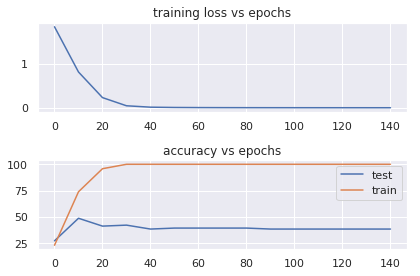

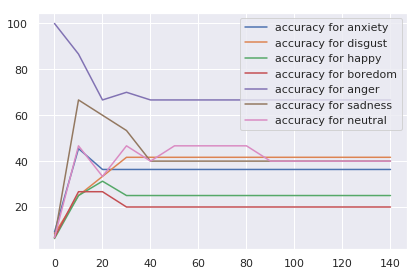

In [19]:
neural_nets.train_model(model_conv, train_input, train_target, test_input, test_target, optimizer, criterion, batch_size, epochs = 150, rate_print = 10, chrono=True, plots=True, save=True, title='conv')

In [20]:
torch.save(model_conv.state_dict(), "results/models/conv_nn_0.pt")
model_conv = neural_nets.convNet()
model_conv.load_state_dict(torch.load("results/models/conv_nn_0.pt"))
model_conv.eval()

convNet(
  (conv1): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 20, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=1280, out_features=21, bias=True)
  (fc2): Linear(in_features=21, out_features=7, bias=True)
)

#### Comparison

clearly the fully connected model is better: faster and more accurate

we overfit rapidly with the simple model, while with the big model doesn't overfit that much easily 

we now look at the confusion matrix of the fully connected neural network

In [22]:
out = model_conv(test_input)
target = test_target
dic = {0:[],1:[],2:[],3:[],4:[],5:[],6:[]}
dic_length = dic

#could do it without for loop, but I think it is clearer
for i, goal in enumerate(target):
    dic[goal.item()].append(torch.argmax(out[i]).item())
matrix = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        matrix[i,j]= np.round(100*len(np.where(np.asarray(dic[i]) == j)[0])/len(np.asarray(dic[i])),decimals = 2)
confusion_matrix = pd.DataFrame(matrix,index = emotion,columns=emotion)
confusion_matrix.to_latex("results/confusion_matrix_conv_nn.tex")
confusion_matrix

,anxiety,disgust,happy,boredom,anger,sadness,neutral
anxiety,30.00,10.00,0.00,0.00,30.00,0.00,30.00
disgust,18.18,36.36,18.18,0.00,0.00,18.18,9.09
happy,13.33,13.33,20.00,6.67,33.33,0.00,13.33
boredom,14.29,7.14,28.57,14.29,7.14,0.00,28.57
anger,10.34,6.90,17.24,0.00,65.52,0.00,0.00
sadness,14.29,7.14,7.14,7.14,7.14,35.71,21.43
neutral,0.00,0.00,21.43,42.86,0.00,0.00,35.71


To make better precision, one way could be to train another model to distinguish between two often mistaken emotions and then take as probability of answer a weigthed average of both

## importance of the variables 

Now basing ourselves on the small model, we can see the influence of each feature we extracted by fitting the model withouth it and looking at the drop in accuracy in the different variables

In [7]:
features = ['length', 'mfcc_mean', 'mfcc_sd', 'mfcc_median', 'mfcc_max', 'mfcc_min',
       'spectral_centroid_mean', 'spectral_centroid_sd',
       'spectral_centroid_median', 'spectral_centroid_max',
       'spectral_centroid_min', 'spectral_rolloff_mean', 'spectral_rolloff_sd',
       'spectral_rolloff_median', 'spectral_rolloff_max',
       'spectral_rolloff_min', 'logfbank_mean', 'logfbank_sd',
       'logfbank_median', 'logfbank_max', 'logfbank_min',
       'spectral_subband_centroid_mean', 'spectral_subband_centroid_sd',
       'spectral_subband_centroid_median', 'spectral_subband_centroid_max',
       'spectral_subband_centroid_min', 'ratio']

we repeat the experience 10 times to get a better estimate of the difference betweent the two different models: each models are **trained on the same train data and evaluated on the same test data**

In [31]:
#creating torch tensor from the dataframe
X = torch.tensor(samples[features].values).type(torch.FloatTensor)
target = torch.tensor(samples["emotion"].values).type(torch.LongTensor)


#splitting the data into test and train
train_input, train_target, test_input, test_target = utilities.split_train_test(X,target)
train_input_modified = train_input[:,:-1]
test_input_modified = test_input[:,:-1]

batch_size = int(train_input.size(0)/10)
epochs = 200


#plot and print parameter
rate_print = 1


model = neural_nets.Net(26)
model.float()
model_ref = neural_nets.Net()
model_ref.float()

learning_rate = 1e-4
# create a stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())
optimizer_ref = torch.optim.Adam(model_ref.parameters())
# create a loss function
criterion = nn.CrossEntropyLoss()

precisions_ref = []
precisions_test = []
precisions_ref_c = []
precisions_test_c = []


for k in range(10):
    model = neural_nets.Net(26)
    model.float()
    model_ref = neural_nets.Net()
    model_ref.float()

    learning_rate = 1e-4
    # create a stochastic gradient descent optimizer
    optimizer = torch.optim.Adam(model.parameters())
    optimizer_ref = torch.optim.Adam(model_ref.parameters())
    # create a loss function
    criterion = nn.CrossEntropyLoss()
    
    neural_nets.train_model(model, train_input_modified, train_target, test_input_modified, test_target, optimizer, criterion, batch_size, epochs, rate_print = epochs-1, chrono=False, plots=False, save=False, title='fully connected')
    neural_nets.train_model(model_ref, train_input, train_target, test_input, test_target, optimizer_ref, criterion, batch_size, epochs, rate_print = epochs-1, chrono=False, plots=False, save=False, title='fully connected')
    
    precisions_test.append(neural_nets.compute_accuracy(model(test_input_modified),test_target))
    precisions_test_c.append(neural_nets.compute_accuracy_per_class(model(test_input_modified),test_target))
    precisions_ref.append(neural_nets.compute_accuracy(model_ref(test_input),test_target))
    precisions_ref_c.append(neural_nets.compute_accuracy_per_class(model_ref(test_input),test_target))


epoch   0, loss training: 1.605, train accuracy 48.364,  test accuracy 42.991
epoch 199, loss training: 0.000, train accuracy 100.000,  test accuracy 71.028
epoch   0, loss training: 1.577, train accuracy 46.028,  test accuracy 36.449
epoch 199, loss training: 0.000, train accuracy 100.000,  test accuracy 73.832
epoch   0, loss training: 1.553, train accuracy 48.364,  test accuracy 41.121
epoch 199, loss training: 0.000, train accuracy 100.000,  test accuracy 71.028
epoch   0, loss training: 1.563, train accuracy 49.533,  test accuracy 38.318
epoch 199, loss training: 0.000, train accuracy 100.000,  test accuracy 66.355
epoch   0, loss training: 1.593, train accuracy 46.963,  test accuracy 41.121
epoch 199, loss training: 0.000, train accuracy 100.000,  test accuracy 70.093
epoch   0, loss training: 1.584, train accuracy 44.860,  test accuracy 42.056
epoch 199, loss training: 0.000, train accuracy 100.000,  test accuracy 71.963
epoch   0, loss training: 1.565, train accuracy 47.897,  t

In [42]:
pr = np.asarray(precisions_ref)
pt = np.asarray(precisions_test)
prc = np.asarray(precisions_ref_c)
ptc = np.asarray(precisions_test_c)
print("difference in total accuracy when dropping ratio: {:4.3f}".format(np.mean(pr-pt)))
diff_accuracy = pd.DataFrame( np.mean(prc-ptc,axis = 0),index = emotion).T
diff_accuracy.to_csv("results/drop_ratio.csv",index=False)
diff_accuracy.head()

difference in total accuracy when dropping ratio: 0.280


,anxiety,disgust,happy,boredom,anger,sadness,neutral
0,0.769231,2.142857,1.176471,1.111111,-1.724138,0.0,0.0


In [41]:
pd.read_csv("results/drop_length.csv").head()

,Unnamed: 0,anxiety,disgust,happy,boredom,anger,sadness,neutral
0,0,-7.142857,7.0,1.111111,3.571429,-1.290323,0.666667,-3.333333


In [40]:
pd.read_csv("results/drop_ratio.csv").head()

,anxiety,disgust,happy,boredom,anger,sadness,neutral
0,0.769231,2.142857,1.176471,1.111111,-1.724138,0.0,0.0


It seems that our model relies on the length of the sound sample to detect differences in disgust, anger happiness, and rely on the ratio between spoken and unspoken feature to identify disgust, sadness anger and happiness

# Other models 

Using `sklearn`, we will try to fit the following models:

   - SVC (support vector classification)
   - multi-logistic regression
   - random forests

#### random forests

In [8]:
X = samples[features].values
y = samples["emotion"].values

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X_train, y_train)
random_forest_importance = pd.DataFrame(np.asarray(clf.feature_importances_), index = features).T
random_forest_importance

,length,mfcc_mean,mfcc_sd,mfcc_median,mfcc_max,mfcc_min,spectral_centroid_mean,spectral_centroid_sd,spectral_centroid_median,spectral_centroid_max,...,logfbank_sd,logfbank_median,logfbank_max,logfbank_min,spectral_subband_centroid_mean,spectral_subband_centroid_sd,spectral_subband_centroid_median,spectral_subband_centroid_max,spectral_subband_centroid_min,ratio
0,0.015275,0.138748,0.014789,0.192672,0.0,0.051591,0.034635,0.003261,0.083362,0.001628,...,0.085779,0.004082,0.009698,0.108236,0.100697,0.059222,0.00078,0.0,0.000868,0.006237


In [10]:
print(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test)))
scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
print(np.mean(scores))

0.5607476635514018
0.5136337353318485


In [11]:
clf_svc = sklearn.svm.SVC(gamma='auto',kernel = 'rbf')
scores = cross_val_score(clf_svc, X, y, cv=5, scoring = 'accuracy')
print(np.mean(scores))

0.23741154071342754


In [12]:
clf = sklearn.linear_model.LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))
scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
print(np.mean(scores))

0.4432908598002937
